Combustion Engines identification using Machine Learning techniques

USP Esalq - MBA Data Science & Analytics - 2022/2

Matheus Felipe Sozza

# 1. Install and Import libraries

In [1]:
# Import modules
%matplotlib inline
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
import scipy.signal
import math
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

# Custom library created for the project
import soundDetection_AuxiliarFunctions

# 2. Map **Audio** files and **Metadata** from file system. Define some **hyperparameters**

In [2]:
# Path related variables
PATH_PROJECT = 'C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/'
PATH_METADATA_FILE = PATH_PROJECT + 'DatasetMapping.csv'
PATH_AUDIOS = PATH_PROJECT + 'UrbanSounds8k/audio/'
PATH_NUM_SUBFOLDERS = 10

# Audio processing variables
AUDIO_SR = 44100 # Audio sampling in Hertz
AUDIO_N_FFT = 2048 # Samples per FFT window
AUDIO_HOP_LEN = 512
AUDIO_N_MELS = 26

# Audio segmentation variables
AUDIOSEG_SIZE = 22050 # samples per segment (500ms)
AUDIOSEG_OVERLAP = 0.5 # normalized

# Debug and test variables
REDUCED_MODE = 1  # Do not process all the audio in the dataset (for faster execution during script development)
REDUCED_MODE_AUDIONUM = 500 # Number of dataset audios to process in the reduced-mode.

# 3. **Audios Dataset** creation (Pandas Table)

In [3]:
#from soundDetection_AuxiliarFunctions import createAudiosDataset
audios_DF = soundDetection_AuxiliarFunctions.createAudiosDataset(PATH_METADATA_FILE, PATH_AUDIOS)
audios_DF.head()

C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold5/100032-3-0-0.wav  ---> Index:  0
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold1/122690-6-0-0.wav  ---> Index:  1000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold2/147926-0-0-44.wav  ---> Index:  2000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold6/162434-6-2-0.wav  ---> Index:  3000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold5/178260-7-1-9.wav  ---> Index:  4000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold4/195969-0-0-19.wav  ---> Index:  5000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold3/30204-0-0-11.wav  ---> Index:  6000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold2/60605-9-0-90.wav  ---> Index:  7000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold2/77751-4-9-1.wav  ---> Index:  8000
Num

,path,filename,fold,duration,class,classID,isEngine
0,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100032-3-0-0.wav,5,0.317551,dog_bark,3,0
1,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100263-2-0-117.wav,5,4.000000,children_playing,2,0
2,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100263-2-0-121.wav,5,4.000000,children_playing,2,0
3,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100263-2-0-126.wav,5,4.000000,children_playing,2,0
4,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100263-2-0-137.wav,5,4.000000,children_playing,2,0


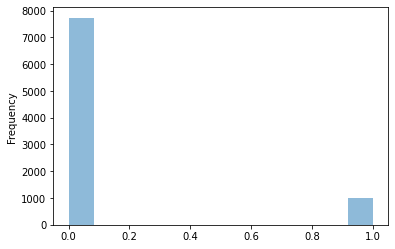

In [4]:
# Audios histogram per type
audios_DF['isEngine'].plot.hist(bins=12, alpha=0.5);

In [5]:
# Audios histogram per duration
#audios_DF['duration'].plot.hist(bins=12, alpha=0.5);
#audios_DF.plot.hist(column=["duration"],by="class", bins=4, alpha=1, figsize=(10, 25));

# 4. **Audios Compilation** creation (audios '.wav' **'array-of-arrays'**)

In [6]:
# Compile all audios in an array of Spectogram Matrices
audio_AA = [] # Audio "array of arrays" (AA) - all audios in one object
spectogram_AM = [] # Spectogram "Array of Matrices" (AM) - all spectogram in one object

# Append all the spectograms matrices in a single array
for idx, rowData in audios_DF.iterrows():
    if(idx%1000 == 0): #Feedback
        print(idx)

    folderNum = audios_DF['fold'][idx];

    audioMatrix = soundDetection_AuxiliarFunctions.loadAudioTrack( audios_DF['path'][idx], arg_sr = AUDIO_SR);
    
    audio_AA.append(audioMatrix); # Append audio data to a single array

    if REDUCED_MODE ==1 and idx == REDUCED_MODE_AUDIONUM : # Reduced mode early stop (test purpose)
        break;

0


# 5. **Segmented audios** subset creation (**data augmentation**)

In [7]:

segAudio_AA = [] ## Subsegmented Audio "array of arrays" (AA) - all segmented audios in one object
isEngine_A = [] # Array containing the information if the audio is an engine

# Prepare the loop through all audios
idxAudio = 0

for audio in audio_AA:
    # Extract data from 'audio'
    segAudioExtracted_AA = []
    isEngineExtracted_A = []
    segAudioExtracted_AA, isEngineExtracted_A = soundDetection_AuxiliarFunctions.extractAudioSubset(audio, 
    audios_DF['isEngine'][idxAudio], AUDIOSEG_OVERLAP, AUDIOSEG_SIZE)

    # Concatenate in a single dataset array all 'segmented audios' + 'isEngine' classification
    segAudio_AA = segAudio_AA + segAudioExtracted_AA #Concatenate
    isEngine_A = isEngine_A + isEngineExtracted_A
    
    idxAudio = idxAudio+1

# 6. **Segmented audios** normalization

In [8]:
# Normalizing dataset using 'Sklearn Normalization' with 'Max' method
segAudioNorm_AA = preprocessing.normalize(segAudio_AA, norm='max')

# A. Appendix 1 - Engine examples and plots

In [9]:
# Engine Audio Example
Audio(segAudioNorm_AA[1960], rate=AUDIO_SR)

Text(80.77777777777779, 0.5, 'Signal')

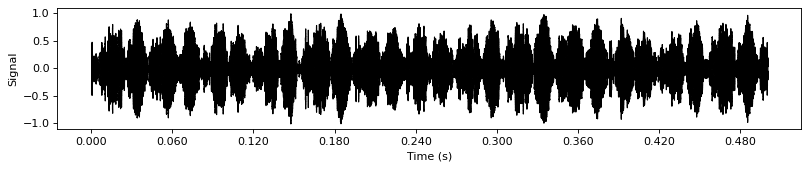

In [10]:
# Plot Audio signal
figure(figsize=(12,2), dpi=80)
librosa.display.waveshow(segAudioNorm_AA[1960], sr= AUDIO_SR, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Signal')

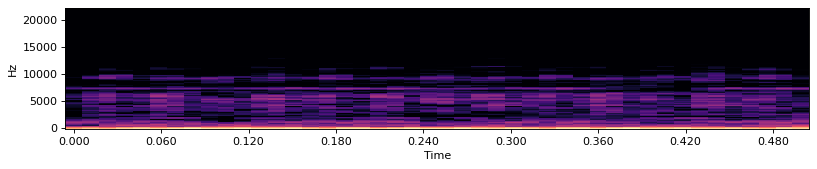

In [11]:
# Engine Spectogram example
figure(figsize=(12,2), dpi=80)
img = librosa.feature.melspectrogram(y=segAudioNorm_AA[1958], sr=AUDIO_SR)
img_DB = librosa.amplitude_to_db(img, ref=np.max)
fig = librosa.display.specshow(img_DB, y_axis='linear', x_axis='time', sr=AUDIO_SR, )

In [12]:
# Engine Audio Example 2
Audio(segAudioNorm_AA[7068], rate=AUDIO_SR)

Text(80.77777777777779, 0.5, 'Signal')

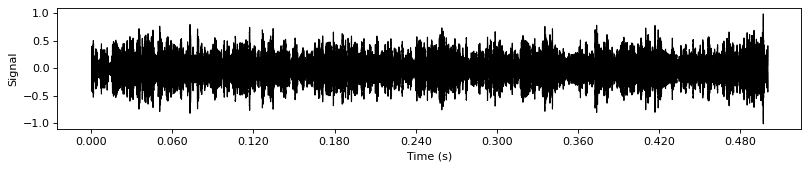

In [13]:
# Plot Audio signal 2
figure(figsize=(12,2), dpi=80)
librosa.display.waveshow(segAudioNorm_AA[7068], sr= AUDIO_SR, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Signal')

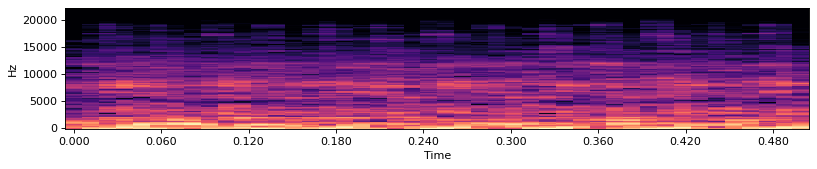

In [14]:
# Engine Spectogram example 2
figure(figsize=(12,2), dpi=80)
img = librosa.feature.melspectrogram(y=segAudioNorm_AA[7068], sr=AUDIO_SR)
img_DB = librosa.amplitude_to_db(img, ref=np.max)
fig = librosa.display.specshow(img_DB, y_axis='linear', x_axis='time', sr=AUDIO_SR, )